In [1]:
from glob import glob
import random

import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

np.random.seed(1984)
random.seed(1984)

In [2]:
train_size = 500
val_size = 1000
test_size = 1000 
data_size = train_size + val_size + test_size

In [3]:
train_size = int(train_size/2)
val_size = int(val_size/2)
test_size = int(test_size/2)
data_size = int(data_size/2)

In [4]:
# get dataset here https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html
yes_files = random.sample(glob("dataset/yes/*.wav"), data_size)
no_files = random.sample(glob("dataset/no/*.wav"), data_size)

In [5]:
yes_data = [wavfile.read(file)[1] for file in yes_files]
no_data = [wavfile.read(file)[1] for file in no_files]

In [6]:
def spectral_density(wav_data):
    power, freqs = plt.psd(wav_data)
    return np.log(power), freqs

In [7]:
freqs = spectral_density(yes_data[1])[1]* 256
yes_power = [spectral_density(wav)[0] for wav in yes_data]
no_power = [spectral_density(wav)[0] for wav in no_data]
plt.close()

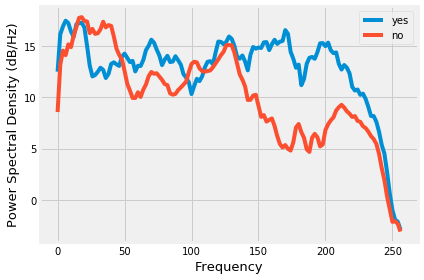

In [8]:
plt.plot(freqs, yes_power[475])
plt.plot(freqs, no_power[91])
plt.xlabel("Frequency", fontsize=13)
plt.ylabel("Power Spectral Density (dB/Hz)", fontsize=13)
plt.legend(["yes","no"])
plt.tight_layout()
#plt.savefig("yesnoexample.png", dpi=500)

----------------------

In [9]:
train = yes_power[:train_size] + no_power[:train_size]
val = yes_power[train_size: train_size + val_size] + no_power[train_size: train_size + val_size] 
test = yes_power[train_size + val_size:] + no_power[train_size + val_size:]

In [10]:
train_labels = train_size*[1] + train_size*[0]
val_labels = val_size*[1] + val_size*[0]
test_labels = test_size*[1] + test_size*[0]

In [11]:
train = list(zip(train, train_labels))
random.shuffle(train)
train_data, train_labels = list(zip(*train))

-------------------

In [12]:
import itertools
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [13]:
def evaluate(targets, preds, method, data):
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds)
    rec = recall_score(targets, preds)
    f1 = f1_score(targets, preds)
    
    print("Results for {} on {} data: \n Acc: {:0.3f}\t Prec: {:0.3f}\t Rec: {:0.3f}\t F1: {:0.3f}".format(method, data, acc, prec, rec, f1))

In [14]:
def plot_confusion_matrix(cm, classes=["Yes","No"],
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.grid(False)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [17]:
# Majority baseline
train_preds = train_size*2*[1]
evaluate(train_labels, train_preds, "Majority", "train")

test_preds = test_size*2*[1]
evaluate(test_labels, test_preds, "Majority", "test")

Results for Majority on train data: 
 Acc: 0.500	 Prec: 0.500	 Rec: 1.000	 F1: 0.667
Results for Majority on test data: 
 Acc: 0.500	 Prec: 0.500	 Rec: 1.000	 F1: 0.667


In [18]:
knn = KNeighborsClassifier(n_neighbors=7).fit(train_data, train_labels)
train_preds = knn.predict(train_data)
evaluate(train_labels, train_preds, "KNN", "train")

val_preds = knn.predict(val)
evaluate(val_labels, val_preds, "KNN", "validation")

test_preds = knn.predict(test)
evaluate(test_labels, test_preds, "KNN", "test")
#plot_confusion_matrix(confusion_matrix(test_labels, test_preds))

Results for KNN on train data: 
 Acc: 0.910	 Prec: 0.929	 Rec: 0.888	 F1: 0.908
Results for KNN on validation data: 
 Acc: 0.891	 Prec: 0.900	 Rec: 0.880	 F1: 0.890
Results for KNN on test data: 
 Acc: 0.902	 Prec: 0.915	 Rec: 0.886	 F1: 0.900


In [19]:
svm = SVC(C=3).fit(train_data, train_labels)
train_preds = svm.predict(train_data)
evaluate(train_labels, train_preds, "SVM", "train")

val_preds = svm.predict(val)
evaluate(val_labels, val_preds, "SVM", "validation")

test_preds = svm.predict(test)
evaluate(test_labels, test_preds, "SVM", "test")
#plot_confusion_matrix(confusion_matrix(test_labels, test_preds))
#plt.savefig("svm.png")

Results for SVM on train data: 
 Acc: 1.000	 Prec: 1.000	 Rec: 1.000	 F1: 1.000
Results for SVM on validation data: 
 Acc: 0.895	 Prec: 0.916	 Rec: 0.870	 F1: 0.892
Results for SVM on test data: 
 Acc: 0.910	 Prec: 0.942	 Rec: 0.874	 F1: 0.907


In [20]:
np.random.seed(1984)
rf = RandomForestClassifier(n_estimators=10).fit(train_data, train_labels)
train_preds = rf.predict(train_data)
evaluate(train_labels, train_preds, "Random Forest", "train")

val_preds = rf.predict(val)
evaluate(val_labels, val_preds, "Random Forest", "validation")

test_preds = rf.predict(test)
evaluate(test_labels, test_preds, "Random Forest", "test")
#plot_confusion_matrix(confusion_matrix(test_labels, test_preds))
#plt.savefig("rfconfusion.png", dpi=400)

Results for Random Forest on train data: 
 Acc: 0.990	 Prec: 1.000	 Rec: 0.980	 F1: 0.990
Results for Random Forest on validation data: 
 Acc: 0.884	 Prec: 0.907	 Rec: 0.856	 F1: 0.881
Results for Random Forest on test data: 
 Acc: 0.906	 Prec: 0.923	 Rec: 0.886	 F1: 0.904


In [15]:
logistic = LogisticRegression(C=100000, penalty="l2").fit(train_data, train_labels)
train_preds = logistic.predict(train_data)
evaluate(train_labels, train_preds, "Naive Logistic", "train")

val_preds = logistic.predict(val)
evaluate(val_labels, val_preds, "Naive Logistic", "validation")

test_preds = logistic.predict(test)
evaluate(test_labels, test_preds, "Naive Logistic", "test")
#plot_confusion_matrix(confusion_matrix(test_labels, test_preds))

Results for Naive Logistic on train data: 
 Acc: 1.000	 Prec: 1.000	 Rec: 1.000	 F1: 1.000
Results for Naive Logistic on validation data: 
 Acc: 0.861	 Prec: 0.848	 Rec: 0.880	 F1: 0.864
Results for Naive Logistic on test data: 
 Acc: 0.899	 Prec: 0.883	 Rec: 0.920	 F1: 0.901


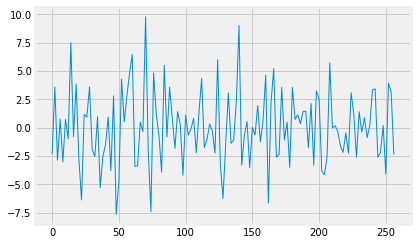

In [16]:
freqs = np.linspace(0, 256, 129, endpoint=True)
plt.plot(freqs, logistic.coef_[0], linewidth=1)

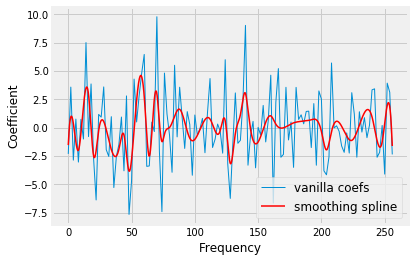

In [19]:
from scipy.interpolate import CubicSpline, LSQUnivariateSpline, BSpline, UnivariateSpline

x_full = np.linspace(0,256,10000)
spline = UnivariateSpline(freqs, logistic.coef_[0], k=3, s=950)      #18
reg_coef = spline(x_full)
plt.plot(freqs, logistic.coef_[0], linewidth=1)
plt.plot(x_full, reg_coef, linewidth=1.5, color="red")
plt.legend(["vanilla coefs", "smoothing spline"], fontsize=12, loc=4)
plt.gcf().subplots_adjust(left=0.125)
plt.xlabel("Frequency")
plt.ylabel("Coefficient")
plt.savefig("splinefitted.png", dpi=400)

In [20]:
reg_coef = spline(freqs)
reg_logistic = LogisticRegression().fit(train_data, train_labels)
reg_logistic.coef_ = reg_coef.reshape(1,129)

In [21]:
train_preds = reg_logistic.predict(train_data)
evaluate(train_labels, train_preds, "Regularized Logistic", "train")

val_preds = reg_logistic.predict(val)
evaluate(val_labels, val_preds, "Regularized Logistic", "validation")

test_preds = reg_logistic.predict(test)
evaluate(test_labels, test_preds, "Regularized Logistic", "test")
#plot_confusion_matrix(confusion_matrix(test_labels, test_preds))
#plt.savefig("reglogistic.png", dpi=400)

Results for Regularized Logistic on train data: 
 Acc: 0.946	 Prec: 0.963	 Rec: 0.928	 F1: 0.945
Results for Regularized Logistic on validation data: 
 Acc: 0.873	 Prec: 0.857	 Rec: 0.896	 F1: 0.876
Results for Regularized Logistic on test data: 
 Acc: 0.917	 Prec: 0.906	 Rec: 0.930	 F1: 0.918


----------------

## with regularization logistic

In [22]:
logisticl2 = LogisticRegression(C=1).fit(train_data, train_labels)
train_preds = logisticl2.predict(train_data)
evaluate(train_labels, train_preds, "Naive logisticl2", "train")

val_preds = logisticl2.predict(val)
evaluate(val_labels, val_preds, "Naive logisticl2", "validation")

test_preds = logisticl2.predict(test)
evaluate(test_labels, test_preds, "Naive logisticl2", "test")

Results for Naive logisticl2 on train data: 
 Acc: 0.988	 Prec: 0.996	 Rec: 0.980	 F1: 0.988
Results for Naive logisticl2 on validation data: 
 Acc: 0.884	 Prec: 0.868	 Rec: 0.906	 F1: 0.886
Results for Naive logisticl2 on test data: 
 Acc: 0.924	 Prec: 0.908	 Rec: 0.944	 F1: 0.925


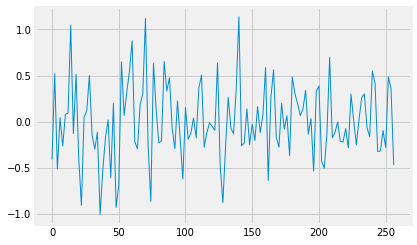

In [23]:
freqs = np.linspace(0, 256, 129, endpoint=True)
plt.plot(freqs, logisticl2.coef_[0], linewidth=1)

---------------------

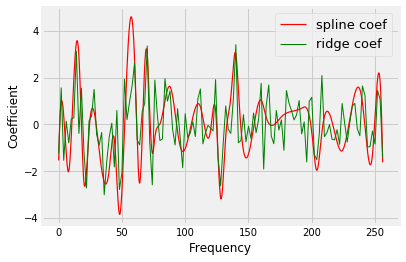

In [24]:
reg_coef = spline(x_full)
#plt.ylim(-6, 7)
plt.plot(x_full, reg_coef, linewidth=1.2, color="red")
plt.plot(freqs, 3*logisticl2.coef_[0], linewidth=1, color="green")
plt.legend(["spline coef", "ridge coef"], fontsize=13)
plt.gcf().subplots_adjust(left=0.125)
plt.xlabel("Frequency")
plt.ylabel("Coefficient")
plt.savefig("l2.png", dpi=400)

In [36]:
noreg_coef = logistic.coef_.ravel()
spline_coef = reg_logistic.coef_.ravel()
l2_coef = 3*logisticl2.coef_.ravel()

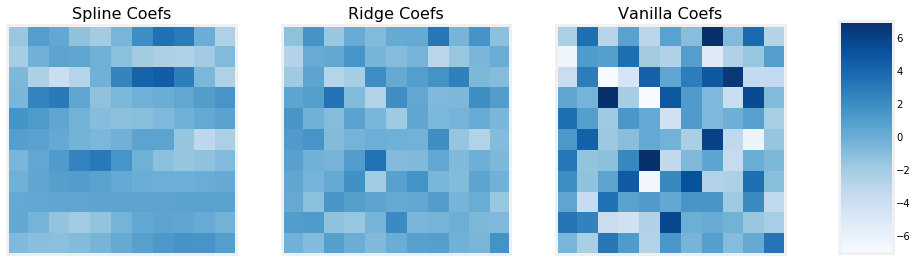

In [124]:
cmap = plt.cm.Blues
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4.6))
ax1 = axes.flat[0]
ax2 = axes.flat[1]
ax3 = axes.flat[2]

im = ax1.imshow(spline_coef[:121].reshape(11,11), vmax=7, vmin=-7, cmap=cmap)
plt.grid(False)
im = ax2.imshow(l2_coef[:121].reshape(11,11), vmax=7, vmin=-7, cmap=cmap)
plt.grid(False)
im = ax3.imshow(noreg_coef[:121].reshape(11,11), vmax=7, vmin=-7, cmap=cmap)
plt.grid(False)
ax1.set_xticks(())
ax2.set_xticks(())
ax3.set_xticks(())
ax1.set_yticks(())
ax2.set_yticks(())
ax3.set_yticks(())
ax1.set_title("Spline Coefs", fontsize=16)
ax2.set_title("Ridge Coefs", fontsize=16)
ax3.set_title("Vanilla Coefs", fontsize=16)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.05, 0.7])

fig.colorbar(im, cax=cbar_ax, fraction=0.01, pad=0.04)
plt.savefig("coefmatrix.png", dpi=400)